In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")        
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [141]:
pwd

'c:\\Users\\user\\KeepMeSafe\\AI_Project'

In [305]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리

# 가정: 'real.csv' 파일에 분석할 실제 데이터가 있으며,
# 여기서는 이미 준비된 10개의 데이터를 사용한다고 가정합니다.

# 데이터 불러오기 및 전처리 (10개 데이터 예시)
df = pd.read_csv("../data/user_code_total/Atest.csv")
# df['RegisterDate'] = pd.to_datetime(df['RegisterDate'])
# df.sort_values(by='RegisterDate', inplace=True)
# df.fillna(method='ffill', inplace=True)
df = df.tail(300)  # 최근 10개 데이터만 사용

# # 심박수 데이터 추출 및 스케일링
# heartbeat_data = df['Heartbeat'].values.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1))
# heartbeat_data_scaled = scaler.fit_transform(heartbeat_data)


# 심박수, 온도, 외부 온도 데이터 추출 및 스케일링
features_data = df[['Heartbeat']].values
scaler = MinMaxScaler(feature_range=(0, 1))
features_data_scaled = scaler.fit_transform(features_data)

# PyTorch 텐서로 변환 및 차원 조정
# X = torch.Tensor(heartbeat_data_scaled).unsqueeze(2)  # [1, 10, 1] 형태로 변환
X = torch.Tensor(features_data_scaled).unsqueeze(1)  # [10, 1, 3] 형태로 변환


# LSTM 기반 오토인코더 모델 정의 (변경 없음)
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        _, (hn, _) = self.encoder(x)
        hn = hn[-1].unsqueeze(0)
        repeated_hn = hn.repeat(1, x.size(1), 1)
        decoded, _ = self.decoder(repeated_hn)
        decoded = decoded.contiguous().view(-1, x.size(2))
        decoded = self.linear(decoded)
        return decoded.view(x.size(0), x.size(1), -1)

# 모델 불러오기 (가정: 학습된 모델이 'best_model.pth'에 저장되어 있음)
model_path = './trainedModel/best_model_ALL.pth'
model = Autoencoder(input_dim=1, hidden_dim=50, num_layers=2).to(device) #input-dim 1->3
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# 데이터에 대한 예측 수행 및 재구성 오차 계산
criterion = torch.nn.MSELoss()  # 평균 제곱 오차 손실 함수
with torch.no_grad():
    outputs = model(X)
    reconstruction_errors = criterion(outputs, X).item()

print(f'재구성 오차: {reconstruction_errors}')

# 재구성 오차를 기반으로 필요한 분석 수행
# 예를 들어, 특정 임계값을 기반으로 이상치 판단 등
    

재구성 오차: 1.9054426957154647e-05


In [306]:
df.tail(300)

,No,WorkDate,UserCode,Heartbeat,Temperature,OutsideTemperature,RegisterDate
0,17096118,20231107,6,85,31.476038,30,2023-11-07 10:00
1,17096135,20231107,6,87,31.476038,30,2023-11-07 10:00
2,17096152,20231107,6,85,31.476038,30,2023-11-07 10:00
3,17096166,20231107,6,83,31.469955,31,2023-11-07 10:00
4,17096180,20231107,6,85,31.469955,31,2023-11-07 10:00
...,...,...,...,...,...,...,...
95,17097899,20231107,6,98,32.553883,33,2023-11-07 10:01
96,17097918,20231107,6,98,32.553883,33,2023-11-07 10:02
97,17097932,20231107,6,97,32.553883,33,2023-11-07 10:02
98,17097950,20231107,6,94,32.571468,33,2023-11-07 10:02


8.494107159652301e-05


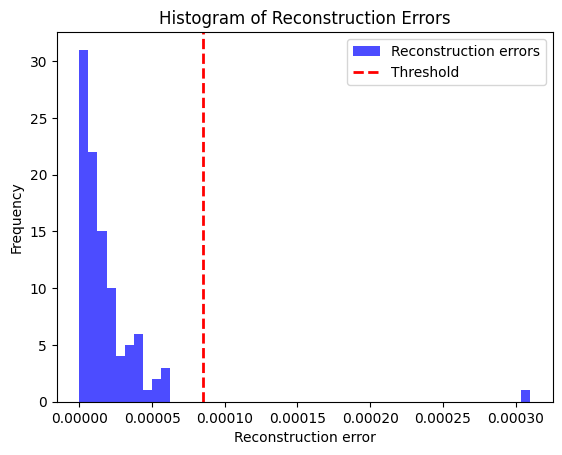

In [307]:
# 재구성 오차 계산
criterion = torch.nn.MSELoss()
reconstruction_errors = []

with torch.no_grad():
    outputs = model(X)
    for i in range(X.size(0)):
        loss = criterion(outputs[i], X[i]).item()
        reconstruction_errors.append(loss)

# 임계값 설정 (이전에 정의한 방식을 그대로 사용)
mean_reconstruction_error = np.mean(reconstruction_errors)
std_reconstruction_error = np.std(reconstruction_errors)
threshold = mean_reconstruction_error + 2 * std_reconstruction_error

print(threshold)

# 재구성 오차 시각화
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='blue', label='Reconstruction errors')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

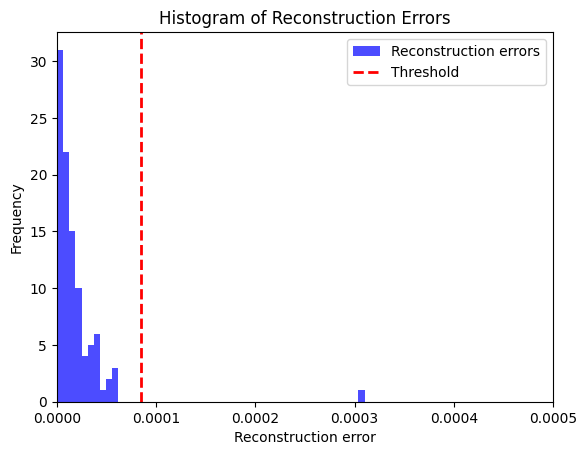

In [308]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ... 이전에 재구성 오차를 계산하는 코드 ...

# 재구성 오차 시각화
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='blue', label='Reconstruction errors')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')

# X 축 레이블 포맷을 소수점 네 자리까지 표시하도록 설정
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))

# 히스토그램의 특정 부분을 확대합니다. 예를 들어, 오차가 0.0000에서 0.0100 사이인 부분만 보려면:
plt.xlim(0, 0.0005)  # 이 범위를 조정하여 원하는 부분을 확대할 수 있습니다.

plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


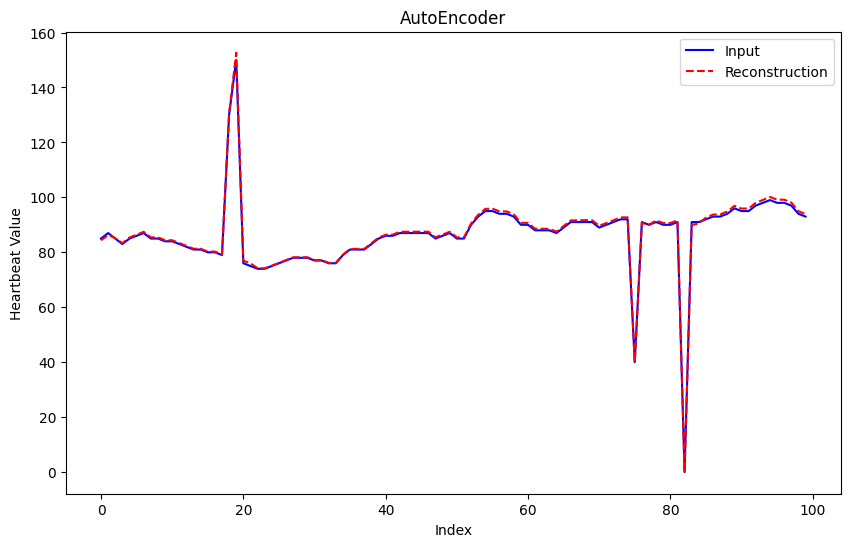

In [309]:
import matplotlib.pyplot as plt

# 예측된 'Heartbeat' 데이터 스케일 되돌리기
predicted_heartbeat = outputs.squeeze(2).detach().numpy()  # 모델 출력을 numpy 배열로 변환
predicted_heartbeat_scaled = scaler.inverse_transform(predicted_heartbeat)  # MinMaxScaler를 사용해 원본 스케일로 변환

# 원본 'Heartbeat' 데이터
original_heartbeat = df['Heartbeat'].values

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 원본 'Heartbeat' 데이터 그래프
plt.plot(original_heartbeat, label='Input', color='blue')

# 예측된 'Heartbeat' 데이터 그래프
plt.plot(predicted_heartbeat_scaled, label='Reconstruction', color='red', linestyle='--')

plt.title('AutoEncoder')
plt.xlabel('Index')
plt.ylabel('Heartbeat Value')
plt.legend()
plt.show()

In [310]:
# 재구성 오차를 기반으로 이상치를 식별합니다.
anomalies = [i for i, error in enumerate(reconstruction_errors) if error > threshold]

# 결과 DataFrame 초기화
results = pd.DataFrame({
    'status': ['SAFE'] * len(df),  # 초기 상태를 'SAFE'로 설정
    'worker_id': df['UserCode'].values  # 'UserCode'를 'worker_id'로 사용
})

# 이상치에 대한 상태를 'CAUTION'으로 업데이트
for idx in anomalies:
    if idx < len(results):  # 인덱스가 결과 DataFrame의 범위 내에 있는지 확인
        results.at[idx, 'status'] = 'CAUTION'

caution_count = sum(results['status'] == 'CAUTION')

        
print(results)

print(f"\n CAUTION count: {caution_count}개")

   status  worker_id
0    SAFE          6
1    SAFE          6
2    SAFE          6
3    SAFE          6
4    SAFE          6
..    ...        ...
95   SAFE          6
96   SAFE          6
97   SAFE          6
98   SAFE          6
99   SAFE          6

[100 rows x 2 columns]

 CAUTION count: 1개


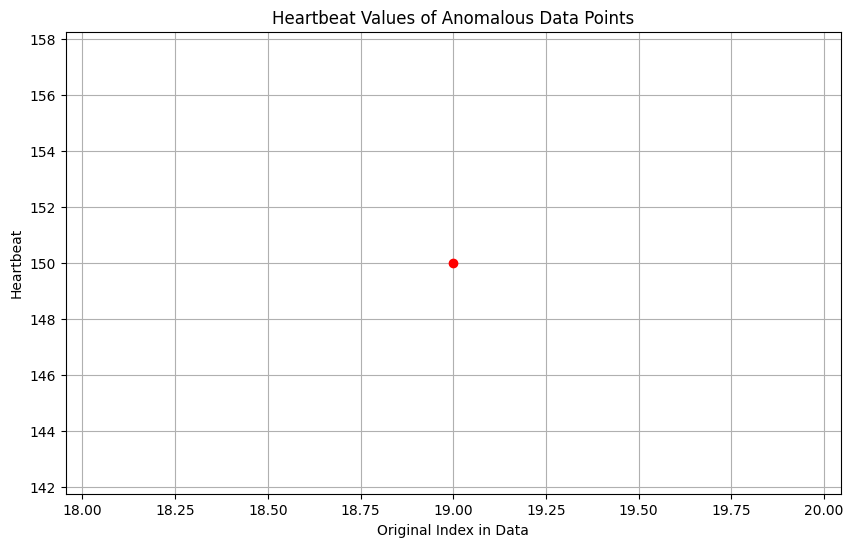

In [311]:
# 임계값을 넘는 데이터의 인덱스 찾기
anomaly_indices = [i for i, error in enumerate(reconstruction_errors) if error > threshold]

# # 해당 인덱스에 해당하는 심박수 값 추출
# anomaly_heartbeats = df.iloc[anomaly_indices]['Heartbeat'].values

# 원본 데이터에서의 실제 인덱스를 추출
original_indices = df.index[anomaly_indices]

# 해당 인덱스에 해당하는 심박수 값 추출
anomaly_heartbeats = df.loc[original_indices, 'Heartbeat'].values

# 추출된 심박수 값과 원본 데이터에서의 인덱스를 사용하여 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(original_indices, anomaly_heartbeats, marker='o', linestyle='-', color='r')
plt.title('Heartbeat Values of Anomalous Data Points')
plt.xlabel('Original Index in Data')
plt.ylabel('Heartbeat')
plt.grid(True)
plt.show()



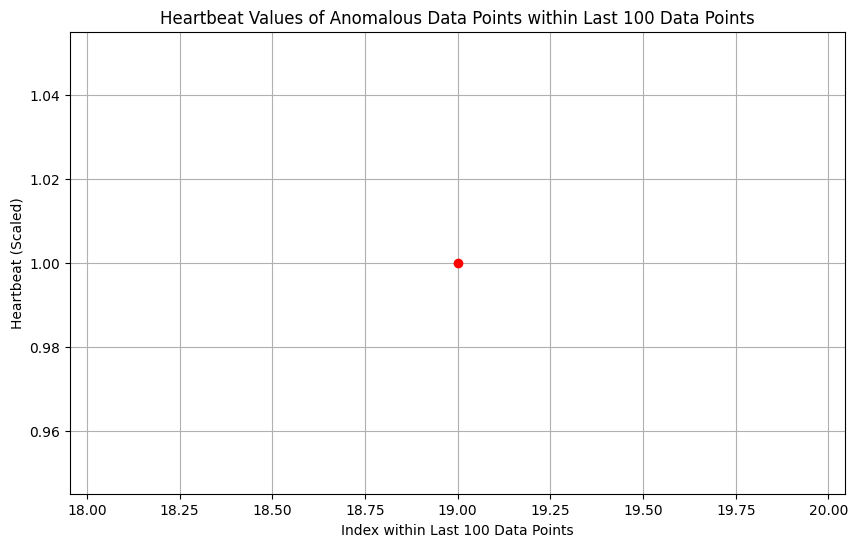

In [312]:
# 필터링된 데이터셋 내에서의 상대적 인덱스를 X축 값으로 사용
# 이미 anomaly_indices가 필터링된 데이터셋의 인덱스를 반영하므로 직접 사용
anomaly_heartbeats = features_data_scaled[anomaly_indices, 0]  # 심박수 데이터 추출

# 추출된 심박수 값과 상대적 인덱스를 사용하여 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(anomaly_indices, anomaly_heartbeats, marker='o', linestyle='-', color='r')
plt.title('Heartbeat Values of Anomalous Data Points within Last 100 Data Points')
plt.xlabel('Index within Last 100 Data Points')
plt.ylabel('Heartbeat (Scaled)')
plt.grid(True)
plt.show()

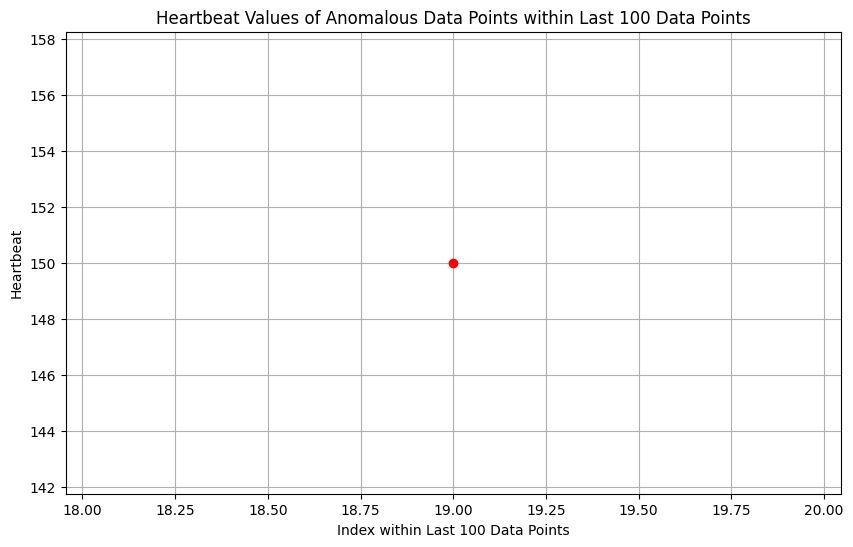

In [313]:
# 필터링된 데이터셋 내에서의 상대적 인덱스를 X축 값으로 사용

# 원본 데이터에서의 실제 인덱스를 추출
original_indices = df.index[anomaly_indices]

# 해당 인덱스에 해당하는 심박수 값 추출
anomaly_heartbeats = df.loc[original_indices, 'Heartbeat'].values

# 이미 anomaly_indices가 필터링된 데이터셋의 인덱스를 반영하므로 직접 사용
# anomaly_heartbeats = features_data_scaled[anomaly_indices, 0]  # 심박수 데이터 추출

# 추출된 심박수 값과 상대적 인덱스를 사용하여 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(anomaly_indices, anomaly_heartbeats, marker='o', linestyle='-', color='r')
plt.title('Heartbeat Values of Anomalous Data Points within Last 100 Data Points')
plt.xlabel('Index within Last 100 Data Points')
plt.ylabel('Heartbeat')
plt.grid(True)
plt.show()